##  Data Preprocessing

This notebook prepares the dataset for modeling by handling missing values, encoding categorical features, and scaling numerical variables where appropriate.

### Goals:
- Clean missing or invalid data
- Rename columns for clarity
- Standardize feature formats (numerical/categorical)
- Apply encoding and scaling techniques as needed
- Output a modeling-ready dataset
---

In [157]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))
from scripts.saver import save_dataset, save_plot
from scripts.eda_plots import plot_numeric_boxplots
from scripts.data_loader import load_raw
from scripts.preprocessing import (rename_columns,
                                  encode_features,
                                   scale_features)


import warnings
warnings.filterwarnings("ignore")


In [158]:
# Load the dataset
df = load_raw("data-corrupted.csv")

##  Handling Missing Values

We divide missing value handling into two categories:
- Drop rows for features with very low missingness (≤ 5%), if they not delete too much data together
- Impute remaining features using median (numerical) or mode (categorical)


In [159]:
missing_report = pd.read_csv("../outputs/reports/missing_report.csv")
missing_report


,col_name,Missing Count,Percentage
0,Mjob,51,12.911392
1,school,31,7.848101
2,Fjob,23,5.822785
3,nursery,23,5.822785
4,paid,19,4.810127
5,traveltime,11,2.784810
6,internet,7,1.772152
7,schoolsup,3,0.759494
8,Dalc,3,0.759494
9,G2,3,0.759494


In [160]:
# Columns with ≤ 5% missingness
drop_threshold = 5.0
drop_cols = missing_report.query("Percentage <= @drop_threshold")["col_name"].tolist()

# Drop rows with missing values in those columns
before = len(df)
df = df.dropna(subset=drop_cols)
after = len(df)

# Report how much data was retained
print(f" Dropped rows with missing values in columns: {drop_cols}")
print(f"➡️ Retained {after} of {before} rows ({after / before:.1%})")


 Dropped rows with missing values in columns: ['paid', 'traveltime', 'internet', 'schoolsup', 'Dalc', 'G2']
➡️ Retained 353 of 395 rows (89.4%)


- As the row-wise deletion strategy preserved 89.4% of the original data, the impact on sample size is minimal and acceptable. We therefore proceed with dropping rows containing missing values in low-missingness columns.




The remaining missing values are confined to four categorical features: `Mjob`, `school`, `Fjob`, and `nursery`. Each has moderate missingness (5–13%) and clearly defined category sets.

Given the nature of these features:
- They are nominal with stable, dominant categories
- Introducing additional categories (e.g., "Unknown") could reduce model interpretability
- The proportion of missingness is not high enough to justify more complex imputation

We therefore impute each column using its mode, preserving the original categorical structure without introducing bias through engineered categories.


In [161]:
# Columns to impute with mode
cols_to_impute_mode = ['Mjob', 'school', 'Fjob', 'nursery']

# Impute each with its mode
for col in cols_to_impute_mode:
    mode_val = df[col].mode()[0]
    df[col].fillna(mode_val, inplace=True)

---

## Renaming Columns for Clarity

To improve interpretability, we rename original column names to more descriptive and standardized versions before encoding.
- Also we'll add   `student_id` column as a unique identifier

In [162]:
df["student_id"] = range(1, len(df) + 1)
# Reorder columns to put student_id first
cols = ["student_id"] + [col for col in df.columns if col != "student_id"]
df = df[cols]

In [163]:
# Display all column names 
print("Current Data Columns:\n")
for col in df.columns:
    print(f"• {col}")


Current Data Columns:

• student_id
• school
• sex
• age
• address
• famsize
• Pstatus
• Medu
• Fedu
• Mjob
• Fjob
• reason
• guardian
• traveltime
• studytime
• failures
• schoolsup
• famsup
• paid
• activities
• nursery
• higher
• internet
• romantic
• famrel
• freetime
• goout
• Dalc
• Walc
• health
• absences
• G1
• G2
• G3


In [164]:
df = rename_columns(df)
print("Current Data Columns:\n")
for col in df.columns:
    print(f"• {col}")


Current Data Columns:

• student_id
• school
• sex
• age
• address
• family_size
• parent_status
• mother_education
• father_education
• mother_job
• father_job
• school_choice_reason
• guardian
• travel_time
• study_time
• past_failures
• school_support
• family_support
• extra_paid_classes
• activities
• attended_nursery
• wants_higher_edu
• internet_access
• in_romantic_relationship
• family_relationship_quality
• free_time
• social_life
• weekday_alcohol_use
• weekend_alcohol_use
• health_status
• absences
• grade_T1
• grade_T2
• final_grade


---

## Encoding Categorical Features

We apply tailored encoding strategies based on the structure of each categorical feature:

- **Binary categorical variables** (e.g., `yes`/`no`, `F`/`M`) are replaced with 0 and 1 for clarity and compatibility with numerical models:
  - `'yes'` → 1, `'no'` → 0  

  - `'F'` → 0, `'M'` → 1  

  - `'GT3'` → 1, `'LE3'` → 0 (indicating family size greater or less than 3)  

  - `'T'` → 1, `'A'` → 0 (`parent_status`: together vs. apart)  
  
  - `'U'` → 1, `'R'` → 0 (`address`: urban vs. rural)

- **Nominal variables with more than two categories**, such as `mother_job`, `father_job`, `guardian`, and `school_choice_reason`, are one-hot encoded.



- For variables like `mother_job`, `father_job`, and `school_choice_reason`, the category `"other"` is not explicitly encoded as a separate column. Instead, it is implicitly represented when all other one-hot encoded category columns for that feature are zero.


This hybrid strategy maintains interpretability, preserves categorical meaning, and ensures compatibility with linear and distance-based models.


In [165]:
df_encoded = df.copy()
df_encoded = encode_features(df_encoded)

In [166]:
print(f"Original shape: {df.shape}")
print(f"Encoded shape: {df_encoded.shape}")
df_encoded.head()


Original shape: (353, 34)
Encoded shape: (353, 40)


,student_id,school,sex,age,address,family_size,parent_status,mother_education,father_education,travel_time,...,guardian_mother,guardian_father,mother_job_teacher,mother_job_health,mother_job_services,father_job_teacher,father_job_services,school_choice_reason_course,school_choice_reason_reputation,school_choice_reason_home
1,1,GP,0,17,1,1,1,1,1,1.0,...,0,1,0,0,0,0,0,1,0,0
2,2,GP,0,15,1,0,1,1,1,1.0,...,1,0,0,0,0,0,0,0,0,0
3,3,GP,0,15,1,1,1,4,2,1.0,...,1,0,0,1,0,0,1,0,0,1
4,4,GP,0,16,1,1,1,3,3,1.0,...,0,1,0,0,0,0,0,0,0,1
5,5,GP,1,16,1,0,1,4,3,1.0,...,1,0,0,0,1,0,0,0,1,0


In [167]:
# Check new columns created
new_cols = [col for col in df_encoded.columns if col not in df.columns]
print("New columns added:")

for col in new_cols:
    print(f"• {col}")


New columns added:
• guardian_mother
• guardian_father
• mother_job_teacher
• mother_job_health
• mother_job_services
• father_job_teacher
• father_job_services
• school_choice_reason_course
• school_choice_reason_reputation
• school_choice_reason_home


---

## Feature Scaling

To ensure all numerical features contribute equally to distance-based and linear models, we apply standardization (z-score scaling). This rescales features to have zero mean and unit variance.

Tree-based models like Random Forest and XGBoost are unaffected by feature scale, so this step is applied only for algorithms where it matters.


In [168]:
df_encoded = scale_features(df_encoded)
df_encoded.head()

Scaled 37 numerical features.


,student_id,school,sex,age,address,family_size,parent_status,mother_education,father_education,travel_time,...,guardian_mother,guardian_father,mother_job_teacher,mother_job_health,mother_job_services,father_job_teacher,father_job_services,school_choice_reason_course,school_choice_reason_reputation,school_choice_reason_home
1,1,GP,-0.920960,0.253066,0.545705,0.646274,0.342182,-1.580103,-1.407961,-0.658351,...,-1.516267,1.862352,-0.362506,-0.287788,-0.519408,-0.251502,-0.606809,1.325825,-0.584983,-0.633083
2,2,GP,-0.920960,-1.328035,0.545705,-1.547330,0.342182,-1.580103,-1.407961,-0.658351,...,0.659514,-0.536955,-0.362506,-0.287788,-0.519408,-0.251502,-0.606809,-0.754247,-0.584983,-0.633083
3,3,GP,-0.920960,-1.328035,0.545705,0.646274,0.342182,1.154095,-0.482430,-0.658351,...,0.659514,-0.536955,-0.362506,3.474777,-0.519408,-0.251502,1.647965,-0.754247,-0.584983,1.579573
4,4,GP,-0.920960,-0.537485,0.545705,0.646274,0.342182,0.242696,0.443101,-0.658351,...,-1.516267,1.862352,-0.362506,-0.287788,-0.519408,-0.251502,-0.606809,-0.754247,-0.584983,1.579573
5,5,GP,1.085823,-0.537485,0.545705,-1.547330,0.342182,1.154095,0.443101,-0.658351,...,0.659514,-0.536955,-0.362506,-0.287788,1.925271,-0.251502,-0.606809,-0.754247,1.709451,-0.633083


### Log-Transformation for skewed columns

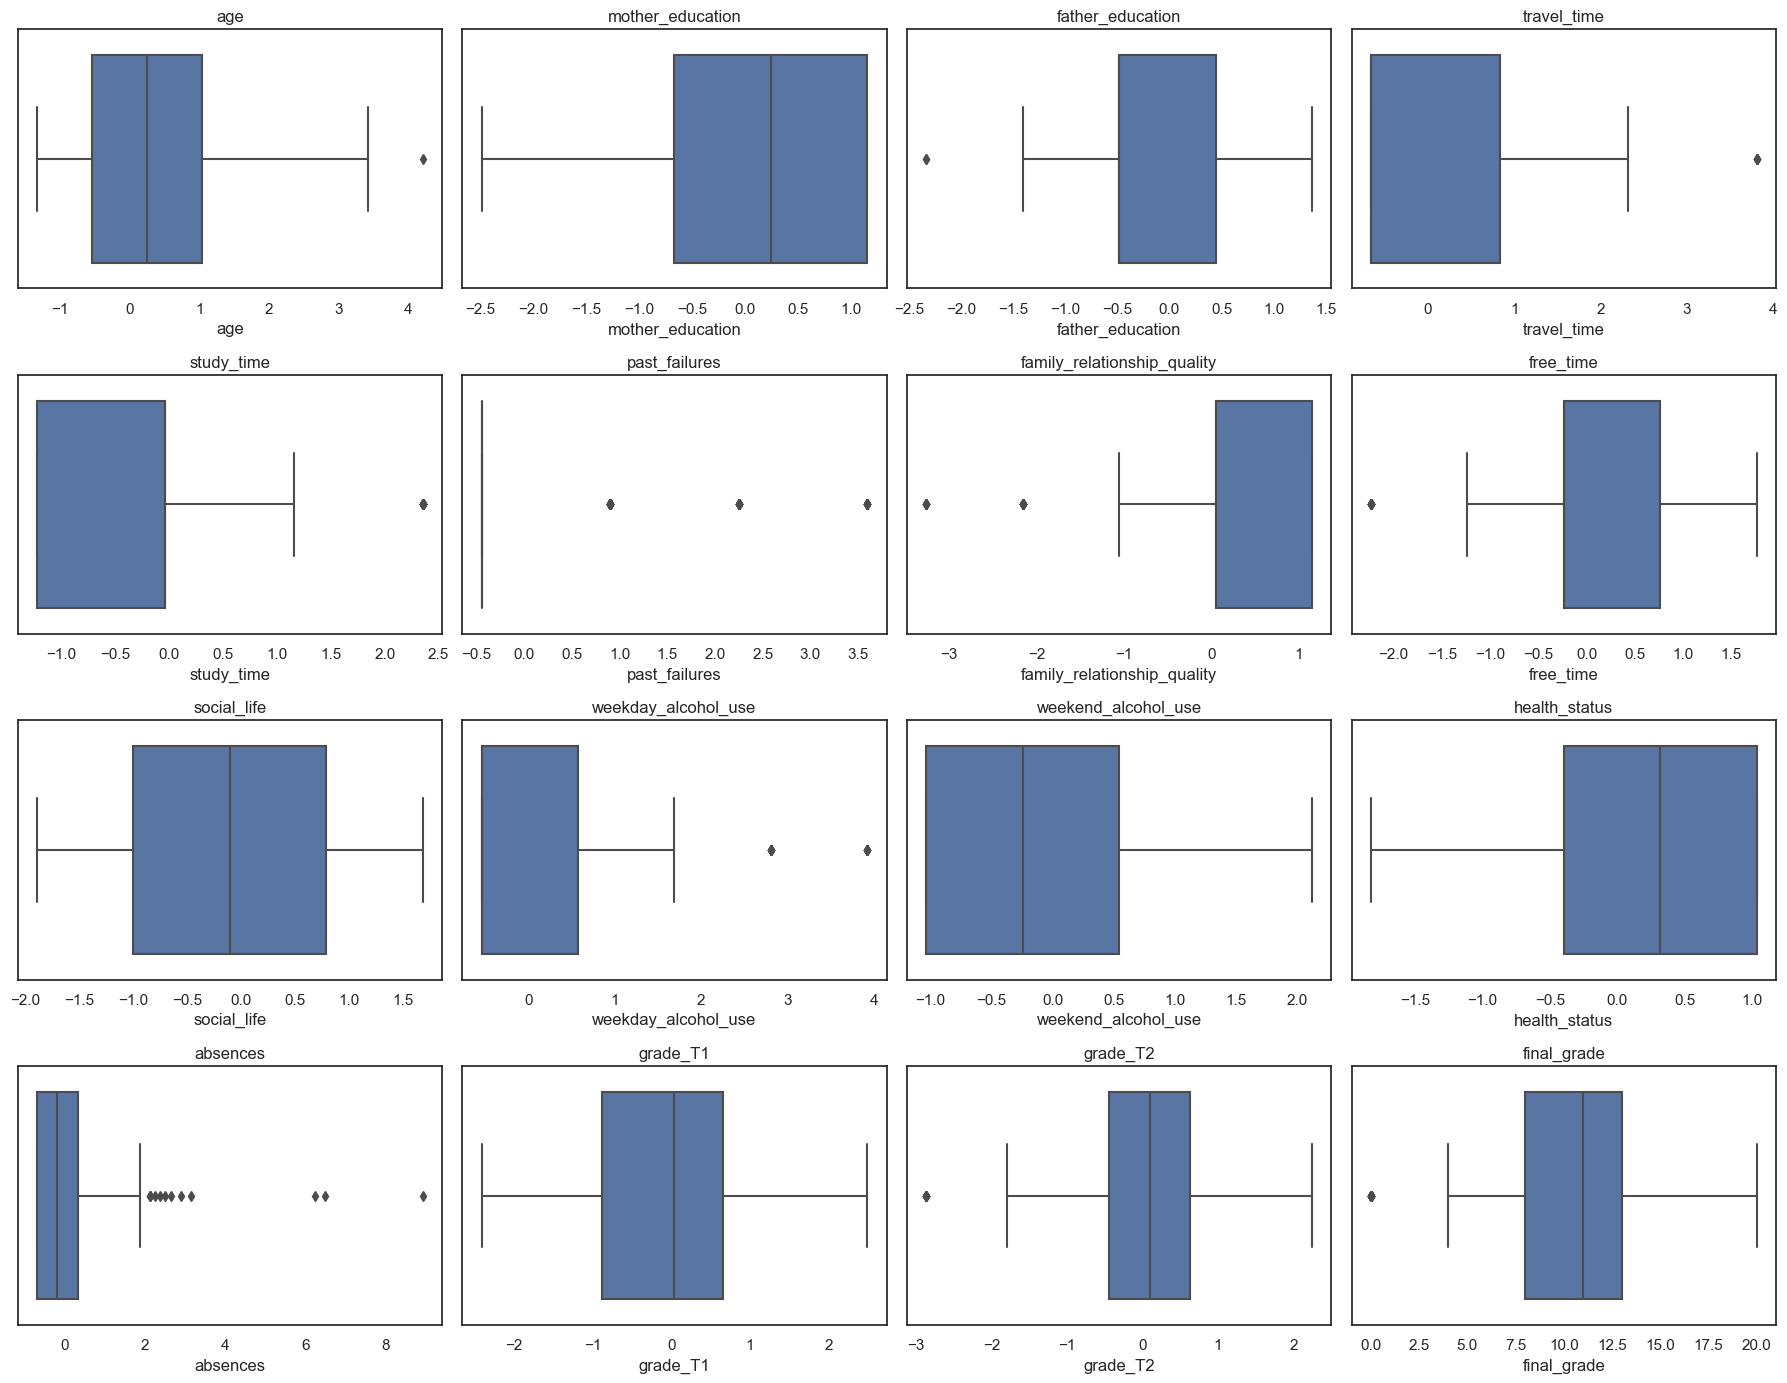

In [169]:
numeric_cols = [
    "age", "mother_education","father_education", "travel_time", "study_time", "past_failures",
    "family_relationship_quality", "free_time", "social_life", "weekday_alcohol_use",  "weekend_alcohol_use",
    "health_status", "absences", "grade_T1", "grade_T2", "final_grade"]

boxplots_not_transformed = plot_numeric_boxplots(df_encoded,numeric_cols)



- The following features were right-skewed with visible outliers: `absences`, `past_failures`, `weekday_alcohol_use`, and `weekend_alcohol_use`. We apply a log transformation to compress their scale and reduce skewness for improved model performance.


In [170]:
log_transform_cols = ["absences", "past_failures", "weekday_alcohol_use", "weekend_alcohol_use"]

for col in log_transform_cols:
    df_encoded[col] = np.log1p(df_encoded[col])

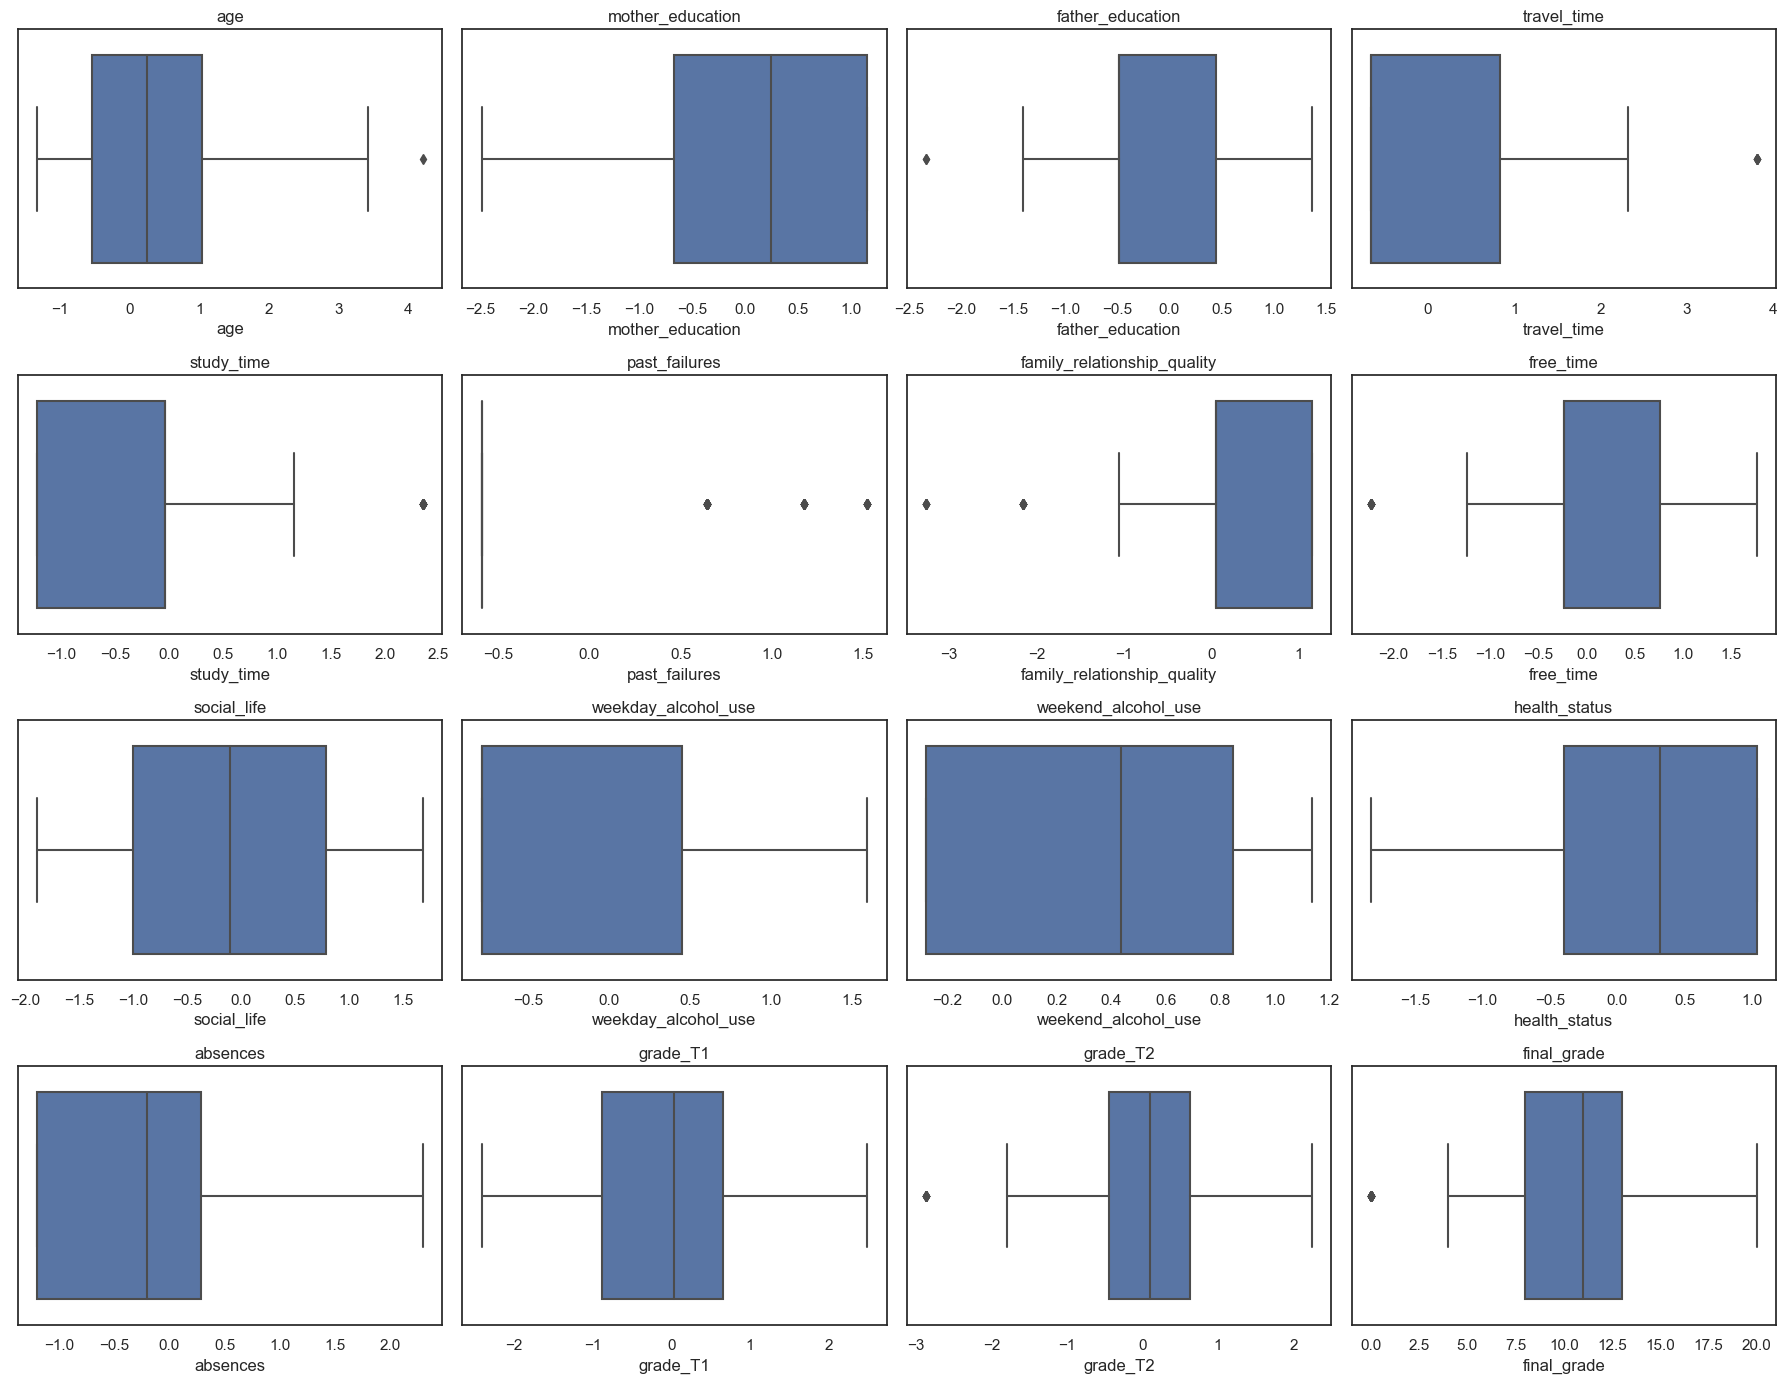

In [171]:
boxplots_transformed = plot_numeric_boxplots(df_encoded,numeric_cols)

## Saving
---

In [175]:
save_dataset(df_encoded, "data-cleaned.csv", folder="data")
save_plot(fig, "boxplot_log_transformed")

Dataset saved to: /Users/titanyanlev/student-performance-ml/data/data-cleaned.csv
Plot saved to: /Users/titanyanlev/student-performance-ml/outputs/plots/boxplot_log_transformed.png
